### To run the notebook in Google Colab, upload this notebook to Colab than run the below cell.

In [ ]:
%cd /content
!git clone https://github.com/hcagri/Dual-Contradistinctive-Generative-Autoencoder.git
%cd /content/Dual-Contradistinctive-Generative-Autoencoder
!pip install sacred
!pip install gdown

## **Dual Contradistinctive Generative Autoencoder - CVPR 2021** 
---
* **Authors:** *Gaurav Parmar, Dacheng Li, Kwonjoon Lee, Zhuowen Tu*
* **Link:** https://arxiv.org/abs/2011.10063
* **Official Implementation:** https://github.com/mlpc-ucsd/DC-VAE

#### **Project Group Members**
* Aybora Köksal aybora@metu.edu.tr
* Halil Çağrı Bilgi cagri.bilgi@metu.edu.tr


# **Paper Summary**


## Introduction

Paper proposes a new generative autoencoder model which leverages contradistinctive loss and a GAN objective together. Proposed model gives significant qualitative and quantitative performance enhancement over the baseline VAEs without architectural changes because using unsupervised contrastive loss in the ELBO objective of VAE instead of simple reconstruction loss, creates less conflict with the GAN loss. Since contrastive loss is asking for being the most similar one among the given training samples unlike the reconstruction loss which wants to have an exact match between the reconstruction with the input. In the original paper, the experiments are conducted on CIFAR-10, STL-10, CelebA, CelebA-HQ, and LSUN bedroom datasets. In Generator and Discriminator, for 32x32 resolution they used architecture found in Autogan, for higher resolutions they used Progressive GAN, however in our project due to limited computational resources, we only reproduced the results for CIFAR-10 dataset. 

## Model Architecture

<p align="center"><img src="https://raw.githubusercontent.com/hcagri/Dual-Contradistinctive-Generative-Autoencoder/master/figures/architecture.png" alt="Architecture" style="height: 600px; width:600px;"/></p>
<p align="center">Figure 1: Encoder, Decoder and Discriminator Architectures</p>

For 32x32 resolution, they have used the discriminator and generator found through neural architecture search in [**AutoGAN**](https://arxiv.org/abs/1908.03835). The encoder is built by modifying the output shape of the final linear layer in the discriminator of AutoGAN. The Encoder, Decoder and Discriminator architectures can be seen in above figure. Figure is taken from the supplementary materials of the original paper.

<p align="center"><img src="https://raw.githubusercontent.com/hcagri/Dual-Contradistinctive-Generative-Autoencoder/master/figures/model.png" alt="Model" style="height: 300px; width:600px;"/></p>
<p align="center">Figure 2: Model architecture for the proposed DC-VAE algorithm.</p>


The overall model architecture of the proposed method is given above. Figure is taken from original paper.




## Dual Contradistinctive Losses 

The ELBO Objective of vanilla VAE
$$L_{ELBO}(\theta, \phi; x) = -E_{z\sim q_{\phi}(z|x)}[log(p_{\theta}(x|z))] + KL[q_{\phi}(z|x) || p(z)] $$ 
Modified ELBO (Implicit ELBO) objective in DC-VAE
$$L_{IELBO}(\theta, \phi, D; x_i) = L_{instance}(\theta, \phi, D;i,\{x_j\}^n_{j=1})+ KL[q_{\phi}(z|x) || p(z)] $$
where, 
$$L_{instance}(\theta, \phi, D;i,\{x_j\}^n_{j=1}) \triangleq -E_{z\sim q_{\phi}(z|x_i)} 
\bigg[ 
log \frac{e^{h(x_i, f_{\theta}(z))}}{\sum_{j=1}^n e^{h(x_j, f_{\theta}(z))}}    
\bigg]$$
$h(.)$ : Cosine Similarity \
$f_{\theta}(z)$ : Reconstruction of $x_i$ \
\
$L_{instance}$ (Instance level fidelity) is modelled by contrastive loss, commonly referred to as [**InfoNCE**](https://arxiv.org/abs/1807.03748v2) loss. An input instance $x_i$ and its reconstruction $f_{\theta}(z)$ comprises a positive pair in DC-VAE. Likewise, the reconstruction $f_{\theta}(z)$ and any instance that is not $x_i$ is a negative pair. \
\
Final objective of DC-VAE algorithm:
$$ 
\underset{\theta, \phi}{min}\ \underset{D}{max} 
\sum_{i=1}^n \big[ L_{IELBO}(\theta, \phi, D; x_i) + L_{GAN}(\theta, \phi, D; x_i)           \big]
$$ 
The first term in the above equation, called instance-level fidelity, encourages the reconstruction to be as close as possible to the input image while being different from all the rest of the images. Since it does not enforce a perfect match, its more relaxed. The second term in the above equation, called set-level fidelity, encourages the entire set of synthesized images to be non distinguishable from the input image set. The authors also considered this term as contrasdistinctive since it tries to minimize the discrimintive classification between the input (“real”) image set and the reconstructed/generated (“fake”) image set.

## Steps of Implementation

1. We defined 3 different optimizers for 3 different blocks in the model;
    - Encoder
    - Decoder
    - Discriminator 
 
    
2. Discriminator Update, use generated and reconstructed samples as negeative samples and  and real data as positive samples, Gan objective is calculated. Then we update only the discriminator parameters.
<p align="center"><img src="https://raw.githubusercontent.com/hcagri/Dual-Contradistinctive-Generative-Autoencoder/master/figures/Step%201.png" alt="Step 1" style="height: 400px; width:600px;"/></p>
3. Reconstructed inputs and samples generated from noise are fed into the discriminator as positive samples, Gan objective is calculated according to those inputs. Encoder and Decoder parameters are updated.
<p align="center"><img src="https://raw.githubusercontent.com/hcagri/Dual-Contradistinctive-Generative-Autoencoder/master/figures/Step%202.png" alt="Step 2" style="height: 400px; width:600px;"/></p>

4. By using real data and corresponding reconstruction results, the contrastive loss is calculated. In contrastive loss, each reconstructed sample constitutes a positive pair with its real input and batch_size-1 negative pairs with all the other inputs inside the batch. After loss is calculated, backward passes are performed on encoder, decoder and discriminator parameters. Also KL digergence is calculated in the reparameterization part between encoder and decoder.
<p align="center"><img src="https://raw.githubusercontent.com/hcagri/Dual-Contradistinctive-Generative-Autoencoder/master/figures/Step%203.png" alt="Step 3" style="height: 400px; width:600px;"/></p>



# Imports

In [1]:
from lib import *

import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

from tqdm.auto import tqdm
import os.path as osp
import os 

import sacred
from sacred import Experiment
from sacred.observers import FileStorageObserver
from sacred import SETTINGS
SETTINGS.CONFIG.READ_ONLY_CONFIG=False

# Hyperparameters & Configurations

In [2]:
configs = {
    'model_params' : {
        'decoder': {
            'latent_dim' : 128,
            'channel_dim' : 256
        },

        'encoder' : {
            'ch_in' : 3,
            'hid_ch': 128,
            'z_dim' : 128
        },

        'discriminator' : {
            'ch_in' : 3, 
            'hid_ch': 128,
            'cont_dim' : 16
        }
    },

    'hparams' : {
        'epochs' : 800,
        'train_batch_size' : 128, 
        'test_batch_size' : 128,
        'lr' : 0.0002,
        'disp_freq' : 20,
        'fid_freq' : 5,
        'gen_train_freq' : 5,
        'checkpoint': 500,
        'beta1' : 0.0,
        'beta2' : 0.9,
        'device' : torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    }
}

model_params = configs["model_params"]
hparams = configs["hparams"]

# **Training**

## Model & Optimizer & Loss Function Initializations

In [4]:
model = Model(model_params)
model.apply(weights_init)

enc_optim = torch.optim.Adam(model.encoder.parameters(), lr = hparams['lr'], betas = (hparams['beta1'], hparams['beta2']))
dec_optim = torch.optim.Adam(model.decoder.parameters(), lr = hparams['lr'], betas = (hparams['beta1'], hparams['beta2']))
disc_optim = torch.optim.Adam(model.discriminator.parameters(), lr = hparams['lr'], betas = (hparams['beta1'], hparams['beta2']))

gan_criterion = torch.nn.BCEWithLogitsLoss()
# contrastive_loss is imported from lib/loss.py

/Users/hcagri/Documents/METU-Master/Term II/CENG 796/project/Dual-Contradistinctive-Generative-Autoencoder/lib/utils.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight.data, 1.)


## Load Datasets

In [3]:
train_loader = DataLoader(
    torchvision.datasets.CIFAR10(
        './data', 
        train = True,
        download = True, 
        transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(
                                (0.5, 0.5, 0.5), 
                                (0.5, 0.5, 0.5)),
                        ])
        ),
    batch_size=hparams['train_batch_size'], 
    shuffle=True, 
    drop_last=True
    )

test_loader = DataLoader(torchvision.datasets.CIFAR10(
    './data', 
    train = False, 
    download = True, 
    transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(
                                (0.5, 0.5, 0.5), 
                                (0.5, 0.5, 0.5)),
                        ])
    ),
    batch_size=hparams['test_batch_size'], 
    shuffle=True
    )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Training Loop and Saving Model

In [ ]:
def train_in_notebook(model_params, hparams, model, gan_criterion, enc_optim ,dec_optim, disc_optim, _run, device = torch.device("cpu")):
    
    model.to(device)

    torch.manual_seed(123)

    if device.type == "cuda":
        torch.cuda.manual_seed(123)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    ####### LOG #######
    disc_train_loss = 0
    gen_train_loss = 0
    cont_train_loss = 0

    mean_generator_loss = 0
    mean_discriminator_loss = 0
    mean_contrastive_loss = 0

    _run.info["gen_loss_train"] = list()
    _run.info["disc_loss_train"] = list()
    _run.info["cont_loss_train"] = list()
    _run.info["fid sampling"] = list()
    _run.info["fid recon"] = list()
    ###################

    disp_freq = hparams['disp_freq']
    step = 1

    for epoch in range(1,hparams['epochs']+1):
        
        iterator = tqdm(train_loader, leave=True)
        iterator.set_description_str(f"Epoch: {epoch}")
        batch_id = 0
        for point_batch, _ in iterator: 

            model.train()
            
            batch_id += 1
            
            model.train()
            model.device = device

            #### Real Data
            real_data = point_batch.to(device) 

            '''----------------         Discriminator Update         ----------------'''
            disc_optim.zero_grad()
            
            fake_data = model.gen_from_noise(size=(real_data.size(0), model_params['decoder']['latent_dim']))
            z_latent, rec_data = model(real_data)

            disc_fake_pred, _ = model.discriminator(fake_data)
            disc_fake_loss = gan_criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

            disc_rec_pred, _ = model.discriminator(rec_data)
            disc_rec_loss = gan_criterion(disc_rec_pred, torch.zeros_like(disc_rec_pred))

            disc_real_pred, _ = model.discriminator(real_data)
            disc_real_loss = gan_criterion(disc_real_pred, torch.ones_like(disc_real_pred))

            gan_objective = disc_real_loss + (disc_rec_loss + disc_fake_loss)*0.5 
            gan_objective.backward(retain_graph = True)
            disc_optim.step()

            ### Log
            _run.info["disc_loss_train"].append(gan_objective.item())
            disc_train_loss = gan_objective.item()
            mean_discriminator_loss += gan_objective.item()
            ########

            '''----------------         Generator Update         ----------------'''
            if step % hparams['gen_train_freq'] == 0:

                # KLD loss term missing !!!!!
                enc_optim.zero_grad()
                dec_optim.zero_grad()
                
                fake_data = model.gen_from_noise(size=(2*real_data.size(0), model_params['decoder']['latent_dim']))
                z_latent, rec_data = model(real_data)

                gen_fake_pred, _ = model.discriminator(fake_data)
                gen_fake_loss = gan_criterion(gen_fake_pred, torch.ones_like(gen_fake_pred))

                gen_rec_pred, _ = model.discriminator(rec_data)
                gen_rec_loss = gan_criterion(gen_rec_pred, torch.ones_like(gen_rec_pred))

                gan_objective =  gen_rec_loss + gen_fake_loss 

                gan_objective.backward(retain_graph = True)
                enc_optim.step()
                dec_optim.step()

                ### Log
                _run.info["gen_loss_train"].append(gan_objective.item())
                gen_train_loss = gan_objective.item()
                mean_generator_loss += gan_objective.item() 
                ########
            
                '''----------------         Contrastive Update         ----------------'''

                enc_optim.zero_grad()
                dec_optim.zero_grad()
                disc_optim.zero_grad()

                z_latent, rec_data = model(real_data)

                _, rec_contrastive = model.discriminator(rec_data)
                _, real_contrastive = model.discriminator(real_data)

                cont_loss = contrastive_loss(z_latent, real_contrastive, rec_contrastive)

                cont_loss.backward()
                
                disc_optim.step()
                enc_optim.step()
                dec_optim.step()

                ### Log
                _run.info["cont_loss_train"].append(cont_loss.item())
                cont_train_loss = cont_loss.item()
                mean_contrastive_loss += cont_loss.item() 
                ########
            
            # Visualize the generated & reconstructed images
            if step % disp_freq == 0:
                gen_images = model.gen_from_noise(size = (25, model_params['decoder']['latent_dim']))
                t_data, _ = iter(test_loader).next()
                t_data = t_data.to(device)
                _ , rec_t_data = model(t_data)
                show_img(gen_images, step, num_images=25, size=(3, 32, 32), img_save_path=osp.join(_run.experiment_info['base_dir'], 'runs', _run._id, 'results'), show=False)
                show_img_rec(t_data, rec_t_data, step, num_images=15, size=(3, 32, 32), img_save_path=osp.join(_run.experiment_info['base_dir'], 'runs', _run._id, 'results'), show=False)
            
            step += 1

            iterator.set_postfix_str(
                f"Disc Loss: {disc_train_loss:.4f}, Gen Loss: {gen_train_loss:.4f}, Cont Loss: {cont_train_loss:.4f}, Step: {step} " )
            
            '''----------------         Save Model at every {hparams['checkpoint']} iteration       ----------------'''
            if step % hparams['checkpoint'] == 0:
                c_name = f"checkpoint_{step}.pt"
                checkpoint_path = osp.join(_run.experiment_info['base_dir'], 'runs', _run._id, "checkpoints", c_name)
                torch.save(model.state_dict(), checkpoint_path)
        
        # Calculate FID Score 
        if epoch % hparams['fid_freq'] == 0:
            fid_samp, fid_rec = eval(model, model_params['decoder']['latent_dim'], hparams['test_batch_size'], device, test_loader)
            print(f"Epoch: {epoch}| sampling fid: {fid_samp}| reconstruction fid: {fid_rec}")
            _run.info["fid sampling"].append(fid_samp)
            _run.info["fid recon"].append(fid_rec)

###
### Training output from 800 epochs of training can be found [here](https://raw.githubusercontent.com/hcagri/Dual-Contradistinctive-Generative-Autoencoder/master/cout.txt).
###

## Initialize Experiment and Start Training

In [ ]:
dirname = osp.dirname(os.path.realpath("__file__"))

experiment_dir = osp.join(dirname, 'runs')

ex = Experiment("ceng796", interactive=True)
ex.observers.append(FileStorageObserver(experiment_dir))
ex.add_config(configs)

@ex.main
def main(_config, _run):
    sacred.commands.print_config(_run)
    
    os.makedirs(osp.join(experiment_dir, _run._id, "checkpoints"))
    os.makedirs(osp.join(experiment_dir, _run._id, "results"))
    
    train_in_notebook(model_params, hparams, model, gan_criterion, enc_optim ,dec_optim, disc_optim, _run, device = hparams['device'])

ex.run()

# **Results**

## Load Pre-trained Model

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dirname = osp.dirname(os.path.realpath("__file__"))
checkpoint_path = osp.join(dirname, 'checkpoint.pt') 

if not osp.exists(checkpoint_path):
    import gdown
    url = 'https://drive.google.com/uc?id=11QNXevBPO7X-Kkgk6UUXXhfa1eF6t0ET'
    gdown.download(url, checkpoint_path, quiet=False)

pre_trained_model_params = torch.load(checkpoint_path, map_location=device)

model = Model(model_params).to(device)
model.device = device
model.load_state_dict(pre_trained_model_params)

<All keys matched successfully>

## Qualitative Results

<p align="center"><img src="https://raw.githubusercontent.com/hcagri/Dual-Contradistinctive-Generative-Autoencoder/master/figures/qualitative.png" alt="Qualitative Results" style="height: 300px; width:500px;"/></p>

<p align="center">Figure 3: Qualitative Results from Paper, Figure 3 (b)</p>

In [4]:
test_loader = DataLoader(torchvision.datasets.CIFAR10(
    './data', 
    train = False, 
    download = True, 
    transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(
                                (0.5, 0.5, 0.5), 
                                (0.5, 0.5, 0.5)),
                        ])
    ),
    batch_size=hparams['test_batch_size'], 
    shuffle=True
)

Files already downloaded and verified


Sampling Results


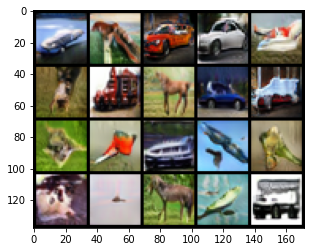

Reconstruction Results 
First two rows are test images, last two rows are corresponding recunstructions


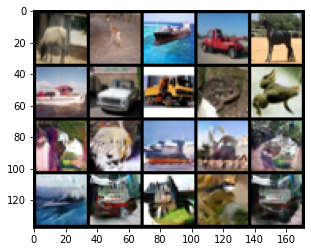

In [15]:
gen_images = model.gen_from_noise(size = (20, model_params['decoder']['latent_dim']))
t_data, _ = iter(test_loader).next()
t_data = t_data.to(device)
_ , rec_t_data = model(t_data)

print("Sampling Results")
show_img(gen_images,step = 1, num_images=25, size=(3, 32, 32), show=True, wandb_save=False)
print("Reconstruction Results \nFirst two rows are test images, last two rows are corresponding recunstructions")
show_img_rec(t_data, rec_t_data, num_images=10, size=(3, 32, 32),  show=True, wandb_save=False)

## Quantitative Results

In [7]:
fid_samp, fid_rec = eval(model, model_params['decoder']['latent_dim'], hparams['test_batch_size'], device, test_loader)
print(f"sampling fid: {fid_samp}| reconstruction fid: {fid_rec}")

100%|██████████| 78/78 [00:37<00:00,  2.06it/s]


sampling fid: 26.71453680343779| reconstruction fid: 91.84300578711182


<p align="center"><img src="https://raw.githubusercontent.com/hcagri/Dual-Contradistinctive-Generative-Autoencoder/master/figures/quantitative.png" alt="Experimental Goal" style="height: 400px; width:300px;"/></p>
<p align="center">Figure 4: Official Results from Paper</p>



**`Our Goal:`** Quantitatively, from Table 2, FID score of DC-VAE Sampling (ours) line on CIFAR-10 dataset will be reproduced.

## Challenges and Discussion

Since our structure is a combination of a variational encoder and a GAN, the biggest challenge we encountered during re-implementation is that in a single iteration the model requires 3 backward passes and making the corresponding optimizer steps (for encoder, decoder, and discriminator, we initialize 3 separate optimizers). So making correct gradient calculations and backward passes took a lot of research, trail&error, and time. We found out that updating discriminative head of discriminator in every step while updating encoder, decoder and contrastive head in every 5 steps gives better result.
\
\
The encoder, decoder and discriminator architectures are provided in the original paper and also can be seen on [Figure 1](#model-architecture). Also the model parameters are mentioned in AutoGAN paper, and the hyper parameters are also mentioned in the original paper. So we do not spend much time to experiment/finding the optimal model&hyper parameters.
\
\
In the experiments as we stated above, we are able to reach as low as 56 FID score in Sampling at CIFAR-10 dataset while in the paper 18 FID is reported. Reconstruction results are also checked both qualitatively and quantitatively as a benchmark and it is obvious that the reconstruction results have some problems. So, in version 2, we aim to improve the performance of our re-implementation by focusing the reconstruction.
\
\
For the loss function we explained in [here](#dual-contradistinctive-losses), we implemented the InfoNCE loss in constrastive head. However, looking at the mentioned papers and the number of negetive samples used in training, the original paper adapts the contrastive loss proposed in [Momentum Contrast for Unsupervised Visual Representation Learning](https://arxiv.org/abs/1911.05722). So in version 1, our re-implementation `does not` include Momentum Contrast. The MoCo paper itself is a very detailed and a challenging algorithm and we do not have much experience in representation learning literature, so until version 2, we will look for a solution to this problem.

## Problems Raised in Review and Discussions


- `In the challenges section, it is said that they need to read the MoCo paper. However, we think that the whole formulation is given in the original paper and could not understand the necessity of it.`  
<br>
In the paper the number of negative samples used for contrastive loss is equal to 8096. In order to reach that high negative sample with the formulation given in the paper is not sufficient. We used that formulation to calculate Contrastive Loss, therefore the number of negative samples we used is limited to the batch_size - 1 for each sample in the batch. 
<br>

- `The paper calculates the FID over 50000 samples. In the reimplementation it is 10000. Due to the batch normalization, it may affect the results.` \
<br>
We tried to calculate FID over 50000 samples, however it slows down the training too much, and didn't effect much the accuracy so we change it back to 10000 
<br> 

- `To calculate the FID, the reimplementation saves the images with cv2.imwrite, which uses ‘BGR’ as its default convention. However, the generated images are in ‘RGB’ space. Therefore, the images are saved with the wrong channel order and Inception network takes these images. We are not sure how real CIFAR10 images’ mu and sigma are calculated.` \
<br> 
Yes this was the reason why we get high FID scores even though our qualitative results were good. When we do this correction our FID score decreased from 56 to 29.
<br>

- `In the notebook it is said that the batch size is not mentioned in the paper. However, batch size is given as 128 in section 5.1 of the paper. The reimplementation uses 64. It may be due to memory constraints.`
<br>
Yes in the first version due to memory contraints we couldn't increase the batch size, for version 2, ve trained the model with a more powerful computer. So we increased the batch size from 64 to 128. In return the FID score decreased from 29 to 24
<br>



## Citation
```
@inproceedings{parmar2021dual,
  title={Dual contradistinctive generative autoencoder},
  author={Parmar, Gaurav and Li, Dacheng and Lee, Kwonjoon and Tu, Zhuowen},
  booktitle={Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition},
  pages={823--832},
  year={2021}
}
```
```
@inproceedings{gong2019autogan,
  title={Autogan: Neural architecture search for generative adversarial networks},
  author={Gong, Xinyu and Chang, Shiyu and Jiang, Yifan and Wang, Zhangyang},
  booktitle={Proceedings of the IEEE/CVF International Conference on Computer Vision},
  pages={3224--3234},
  year={2019}
}
```
```
@inproceedings{he2020momentum,
  title={Momentum contrast for unsupervised visual representation learning},
  author={He, Kaiming and Fan, Haoqi and Wu, Yuxin and Xie, Saining and Girshick, Ross},
  booktitle={Proceedings of the IEEE/CVF conference on computer vision and pattern recognition},
  pages={9729--9738},
  year={2020}
}
```
```
@article{oord2018representation,
  title={Representation learning with contrastive predictive coding},
  author={Oord, Aaron van den and Li, Yazhe and Vinyals, Oriol},
  journal={arXiv preprint arXiv:1807.03748},
  year={2018}
}
```